# RNN

- 潜变量自回归模型

使用潜变量$h_t$总结过去信息
![title](attachment/rnn.png)

- 循环神经网络（RNN）
![title](attachment/rnn2.png)

更新隐藏状态
$$
h_t = \phi(W_{hh}h_{t-1} + W_{hx}x_{t-1} + b_h)\\
o_t = \phi(W_{ho}h_t + b_o)
$$

- 困惑度（perplexity）

衡量一个语言模型的好坏可以用平均交叉熵。

$$\pi = \frac{1}{n}\sum-logp(x_t|x_{t-1}...) $$

NLP 用困惑度 $exp(\pi)$ 衡量，1表示完美

- 梯度剪裁

如果梯度长度超过$\theta$, 那么拖影回长度$\theta$

$$\pmb g \leftarrow min(1, \frac{\theta}{||\pmb g||}\pmb g)$$

ps：

pip install d2l

pip install matplotlib==3.0.0

In [1]:
import os
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from d2l import torch as d2l
import matplotlib.pyplot as plt
import collections
import re
import numpy as np

# Artifical Code

In [2]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [3]:
F.one_hot(torch.tensor([0,2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [4]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

In [5]:
def get_params(vocab_size, num_hiddens, device):
  num_inputs = num_outputs = vocab_size

  def normal(shape):
    return torch.randn(size=shape, device=device)*0.01

  # 隐藏层参数
  W_xh = normal((num_inputs, num_hiddens))
  W_hh = normal((num_hiddens, num_hiddens))
  b_h = torch.zeros(num_hiddens, device=device)

  # 输出层参数
  W_hq = normal((num_hiddens, num_outputs))
  b_q = torch.zeros(num_outputs, device=device)

  # 附加梯度
  params = [W_xh, W_hh, b_h, W_hq, b_q]
  for param in params:
    param.requires_grad_(True)
  return params

In [6]:
def init_rnn_state(batch_size, num_hiddens, device):
  return (torch.zeros((batch_size, num_hiddens), device=device), )

In [7]:
def rnn(inputs, state, params):
  # inputs的形状：(时间步数量，批量⼤⼩，词表⼤⼩)
  W_xh, W_hh, b_h, W_hq, b_q = params
  H, = state
  outputs = []
  # X的形状：(批量⼤⼩，词表⼤⼩)
  for X in inputs:
    H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
    Y = torch.mm(H, W_hq) + b_q
    outputs.append(Y)
  return torch.cat(outputs, dim=0), (H,)

In [8]:
class RNNModelScratch: 
  """从零开始实现的循环神经⽹络模型"""
  def __init__(self, vocab_size, num_hiddens, device,
         get_params, init_state, forward_fn):
    self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
    self.params = get_params(vocab_size, num_hiddens, device)
    self.init_state, self.forward_fn = init_state, forward_fn

  def __call__(self, X, state):
    X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
    return self.forward_fn(X, state, self.params)

  def begin_state(self, batch_size, device):
    return self.init_state(batch_size, self.num_hiddens, device)

In [9]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
            init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [10]:
def predict_ch8(prefix, num_preds, net, vocab, device): 
  """在prefix后⾯⽣成新字符"""
  state = net.begin_state(batch_size=1, device=device)
  outputs = [vocab[prefix[0]]]
  get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
  for y in prefix[1:]: # 预热期
    _, state = net(get_input(), state)
    outputs.append(vocab[y])

  for _ in range(num_preds): # 预测num_preds步
    y, state = net(get_input(), state)
    outputs.append(int(y.argmax(dim=1).reshape(1)))

  return ''.join([vocab.idx_to_token[i] for i in outputs])


In [11]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller kg kg kg k'

## Grad Clip

对于⻓度为T的序列，我们在迭代中计算这T个时间步上的梯度，将会在反向传播过程中产⽣⻓度为O(T)的
矩阵乘法链。如4.8节所述，当T较⼤时，它可能导致数值不稳定，例如可能导致梯度爆炸或梯度消失。因此，
循环神经⽹络模型往往需要额外的⽅式来⽀持稳定训练。

In [12]:
def grad_clipping(net, theta):
  if isinstance(net, nn.Module):
    params = [p for p in net.parameters() if p.requires_grad]
  else:
    params = net.params
  norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
  if norm > theta:
    for param in params:
      param.grad[:] *= theta / norm

## Train

In [13]:
loss = nn.CrossEntropyLoss()
opt = torch.optim.SGD(net.params, lr=1)
state = None
epochs = 500


perplexity = []
for epoch in range(epochs):
  epoch_loss = []
  for X, Y in train_iter:
    y = Y.T.reshape(-1)
    X, y = X.cuda(), y.cuda()
    state = net.begin_state(batch_size=X.shape[0], device=0)
    y_hat, state = net(X, state)
    # state 是叶子节点，不可以直接设置grad
    state = (state[0].detach(),)
    l = loss(y_hat, y.long()).mean()
    epoch_loss.append(l.item())
    
    opt.zero_grad()
    l.backward()
    grad_clipping(net,1)
    opt.step()
    
  perplexity.append(np.exp(np.mean(epoch_loss)))
  


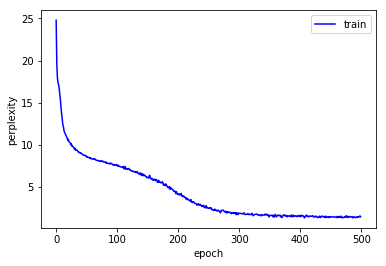

In [14]:
plt.plot(perplexity, label='train', color='b', linestyle='solid')
plt.xlabel('epoch')
plt.ylabel('perplexity')
plt.legend()
plt.show()

In [15]:
print(predict_ch8('time traveller ', 50, net, vocab, d2l.try_gpu()))

time traveller smiled are you sure we can move freely inspace rig
